# ISEG-Master Final Work
# XAI-based dropout prediction and personalized educational recommendations.

In [1]:
# =============================================================
# PERSONALIZED RECOMMENDATION MODEL:CatBoost + SHAP
# =============================================================

# --------Methodology-----------------
#Raw Data
 #  ↓
#Feature Engineering
  # ↓
#CatBoost → Prob(dropout)
 #  ↓
#Rules Engine
 #  ↓
#Personalized Recommendation

# =============================================================
# UNIFIED PIPELINE
# 1) Preproc
# 2) X/y 
# 3) Models 
# 4) XAI: Feature importance
# 5) XAI: SHAP Global
# 6) XAI: SHAP Beeswarm 
# 7) XAI: ALE Global
# 8) XAI: SHAP Local 
# 9) Model Recommendations con XAI main drivers
# 10) Rename for reports & export
# =============================================================


## Installs

In [3]:
# -------------------------
# Installs: 
# -------------------------
!pip install xgboost lightgbm catboost shap umap-learn alepython matplotlib seaborn
# ===========================================================

import sys
import subprocess
import platform

def install(package):
    """Safe installer that prints errors instead of crashing."""
    try:
        print(f"\n🔧 Installing {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f" {package} installed successfully")
    except Exception as e:
        print(f" Could NOT install {package}: {e}")

# Identify OS
os_type = platform.system()
print(f"\n Detected operating system: {os_type}")

# ------------------------------
# 1. Always safe installations
# ------------------------------
install("xgboost")
install("shap")
install("alepython")
install("umap-learn")

# ------------------------------
# 2. LightGBM — OS-dependent
# ------------------------------
if os_type == "Windows":
    print("\n LightGBM requires a special version on Windows...")
    install("lightgbm")
else:
    install("lightgbm")

# ------------------------------
# 3. CatBoost — works on all OS
# ------------------------------
install("catboost")

print("\n FULL ENVIRONMENT READY — all models and interpretability tools installed!")



 Detected operating system: Windows

🔧 Installing xgboost ...


ERROR: Could not find a version that satisfies the requirement alepython (from versions: none)
ERROR: No matching distribution found for alepython


 xgboost installed successfully

🔧 Installing shap ...
 shap installed successfully

🔧 Installing alepython ...
 Could NOT install alepython: Command '['C:\\Users\\MSI Prestige\\anaconda3\\python.exe', '-m', 'pip', 'install', 'alepython']' returned non-zero exit status 1.

🔧 Installing umap-learn ...
 umap-learn installed successfully

 LightGBM requires a special version on Windows...

🔧 Installing lightgbm ...
 lightgbm installed successfully

🔧 Installing catboost ...
 catboost installed successfully

 FULL ENVIRONMENT READY — all models and interpretability tools installed!


## 1) OULAD Dataset - Download and Preparation

In [5]:
# ========================================= 
# 1. Download the dataset from the official OULAD site.
# 2. Unzip the files into the oulad_data folder.
# 3. Load each .csv file into a pandas DataFrame dictionary.
# 4. Merge the key tables (studentInfo + studentRegistration + studentVle) to get profile + registration + interaction data.
# =========================================

import os
import pandas as pd
import zipfile
import urllib.request

# 1. Download dataset
zip_file = "anonymisedData.zip"
url = "https://analyse.kmi.open.ac.uk/open_dataset/download"

if not os.path.exists(zip_file):
    print("Downloading OULAD dataset...")
    urllib.request.urlretrieve(url, zip_file)
else:
    print("Dataset already downloaded.")

# 2. Extract dataset 
extract_dir = "oulad_data"
if not os.path.exists(extract_dir):
    print("Extracting files...")
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print("Dataset already extracted.")

# 3. Load all CSV files into a dictionary of DataFrames
data = {}
for file in os.listdir(extract_dir):
    if file.endswith(".csv"):
        path = os.path.join(extract_dir, file)
        df_name = file.replace(".csv", "")
        data[df_name] = pd.read_csv(path)
        print(f"Loaded {df_name}: {data[df_name].shape}")

# 4. Select key tables for the MFW
students = data["studentInfo"]
registrations = data["studentRegistration"]
vle = data["studentVle"]

# 5. Merge tables
merged = students.merge(registrations, on=["id_student", "code_module", "code_presentation"], how="left")
merged = merged.merge(vle, on=["id_student", "code_module", "code_presentation"], how="left")

print("\nMerged dataset shape:", merged.shape)

# Validation: Random sample of 50 rows
sample = merged.sample(50, random_state=42)
print("\nSample data preview:")
print(sample.head())

# Export sample to Excel to check output
output_file = "table_merged_sample.xlsx"
sample.to_excel(output_file, index=False)
print(f"\n Excel sample exported as: {output_file}")



Dataset already downloaded.
Dataset already extracted.
Loaded assessments: (206, 6)
Loaded courses: (22, 3)
Loaded studentAssessment: (173912, 5)
Loaded studentInfo: (32593, 12)
Loaded studentRegistration: (32593, 5)
Loaded studentVle: (10655280, 6)
Loaded vle: (6364, 6)

Merged dataset shape: (10658645, 17)

Sample data preview:
        code_module code_presentation  id_student gender  \
7823360         FFF             2013J      582950      M   
396361          BBB             2013B      331354      F   
3238252         DDD             2013B      386833      M   
9992755         FFF             2014J      683745      M   
6059197         EEE             2014J      649255      M   

                       region      highest_education imd_band age_band  \
7823360              Scotland       HE Qualification   30-40%     0-35   
396361   North Western Region  A Level or Equivalent   20-30%     0-35   
3238252         London Region       HE Qualification    10-20    35-55   
9992755    

## 1) OULAD - Preprocessing Pipeline

In [7]:
## =========================================
# # 1. Merge the relevant tables.
# 2. Create the target variable (dropout = 1 if the student withdrew, 0 otherwise).
# 3. Generate initial features from demographic and interaction data.
# 4. Leave the dataset clean and ready for modeling.

# =========================================
# Target: create a binary variable dropout (1 = withdrawn, 0 = not withdrawn).
# Demographics: transform variables such as gender, prior education, age, region.
# Registration: calculate features derived from registration (e.g., enrollment days).
# Interaction (VLE): generate click metrics (total, average, maximum, number of interactions).
# Returns a dataset X (features) and y (target) ready for training.
# =========================================

import pandas as pd
import numpy as np
import os

# Load data
data_dir = "oulad_data"

studentInfo = pd.read_csv(os.path.join(data_dir, "studentInfo.csv"))
studentRegistration = pd.read_csv(os.path.join(data_dir, "studentRegistration.csv"))
studentVle = pd.read_csv(os.path.join(data_dir, "studentVle.csv"))

# =============================
# Step 1: Create target variable
# =============================
# final_result categories: "Withdrawn", "Fail", "Pass", "Distinction"
studentInfo["dropout"] = studentInfo["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# =============================
# Step 2: Feature engineering
# =============================

# ---- Demographics ----
features = studentInfo[[
    "id_student", "code_module", "code_presentation",
    "gender", "region", "highest_education", "imd_band",
    "age_band", "num_of_prev_attempts", "studied_credits", "disability",
    "dropout"
]]

# Encode categorical variables
categorical_cols = ["gender", "region", "highest_education", "imd_band", "age_band", "disability"]
features = pd.get_dummies(features, columns=categorical_cols, drop_first=True)

# ---- Registration features ----

reg_agg = (
    studentRegistration
    .groupby("id_student")
    .agg(
        date_registration=("date_registration", "min")
    )
    .reset_index()
)

features = features.merge(reg_agg, on="id_student", how="left")

# ---- Interaction features (VLE clicks) ----
vle_agg = studentVle.groupby("id_student").agg({
    "sum_click": ["sum", "mean", "max", "count"]
})
vle_agg.columns = ["total_clicks", "avg_clicks", "max_clicks", "num_interactions"]
vle_agg = vle_agg.reset_index()

features = features.merge(vle_agg, on="id_student", how="left")

# Fill missing values
features = features.fillna(0)

# =============================
# Step 3: Final dataset
# =============================
print("Final dataset shape:", features.shape)
print("\nSample data:")
print(features.head())


# Export final dataset to Excel
output_file = "final_dataset.xlsx"
features.to_excel(output_file, index=False)
print(f"\n Excel file exported successfully: {output_file}")

# =============================
# FINAL DATASET (MASTER)
# =============================
features_df = features.copy()


Final dataset shape: (32593, 40)

Sample data:
   id_student code_module code_presentation  num_of_prev_attempts  \
0       11391         AAA             2013J                     0   
1       28400         AAA             2013J                     0   
2       30268         AAA             2013J                     0   
3       31604         AAA             2013J                     0   
4       32885         AAA             2013J                     0   

   studied_credits  dropout  gender_M  region_East Midlands Region  \
0              240        0      True                        False   
1               60        0     False                        False   
2               60        1     False                        False   
3               60        0     False                        False   
4               60        0     False                        False   

   region_Ireland  region_London Region  ...  imd_band_80-90%  \
0           False                 False  ...        

## 2) Split X and y for modeling

In [9]:
# =============================
# MODEL DATASET (FROZEN)
# =============================

X_model = features_df.drop(columns=["id_student", "dropout"])
y = features_df["dropout"]

X_model = pd.get_dummies(X_model, drop_first=True)
X_model.columns = X_model.columns.str.replace(r'[\[\]<> ]', '_', regex=True)

print("X_model shape:", X_model.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.30, random_state=42, stratify=y
)


X_model shape: (32593, 45)


## 3) Modeling for dropout probability

In [11]:
# ======================================================
# MODELING PIPELINE (LOGIT + RF + XGB + LGBM + CATBOOST)
# ======================================================

import sys
import subprocess
import pandas as pd
import numpy as np

# ------------------------------------------------------
# Helper: install library if missing
# ------------------------------------------------------
def install_if_missing(package):
    try:
        __import__(package)
        print(f"✔ {package} available")
        return True
    except ImportError:
        print(f" Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        try:
            __import__(package)
            print(f" {package} installed successfully")
            return True
        except:
            print(f" Could not install {package}")
            return False

# ------------------------------------------------------
# Installing advanced models
# ------------------------------------------------------
xgb_available = install_if_missing("xgboost")
lgb_available = install_if_missing("lightgbm")
cat_available = install_if_missing("catboost")

# ------------------------------------------------------
# Imports after installation
# ------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

if xgb_available:
    from xgboost import XGBClassifier

if lgb_available:
    import lightgbm as lgb

if cat_available:
    from catboost import CatBoostClassifier


✔ xgboost available
✔ lightgbm available
✔ catboost available


In [12]:
# ------------------------------------------------------
# Train all available -BASE
# ------------------------------------------------------

models = {}

# Logistic Regression 
log_reg = LogisticRegression(
    C=0.1,
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"
)
log_reg.fit(X_train, y_train)
models["Logistic_Regression"] = log_reg

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)
models["RandomForest"] = rf

# XGBoost
if xgb_available:
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    xgb.fit(X_train, y_train)
    models["XGBoost"] = xgb

# LightGBM
if lgb_available:
    lgbm = lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=-1,
        num_leaves=31,
        learning_rate=0.05,
        random_state=42
    )
    lgbm.fit(X_train, y_train)
    models["LightGBM"] = lgbm

# CatBoost
if cat_available:
    cb = CatBoostClassifier(
        iterations=300,
        depth=4,
        learning_rate=0.1,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=42,
        verbose=0
    )
    cb.fit(X_train, y_train)
    models["CatBoost"] = cb



C:\Users\MSI Prestige\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:48:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 7109, number of negative: 15706
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 22815, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311593 -> initscore=-0.792681
[LightGBM] [Info] Start training from score -0.792681


In [13]:
# ------------------------------------------------------
# Generate predictions + probabilities
# ------------------------------------------------------
preds = {}
probas = {}

for name, model in models.items():
    preds[name] = model.predict(X_test)
    try:
        probas[name] = model.predict_proba(X_test)[:, 1]
    except:
        probas[name] = np.zeros(len(X_test))

# ------------------------------------------------------
# Function for all metrics
# ------------------------------------------------------
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_proba)
    }

# ------------------------------------------------------
# Build results table
# ------------------------------------------------------
results = {
    name: get_metrics(y_test, preds[name], probas[name])
    for name in models.keys()
}

results_df = pd.DataFrame(results).T.round(3)

print("\n=== Comparative Table of All Models (Optimized) ===")
# Ordenamos los resultados de mayor a menor ROC-AUC
display(results_df.sort_values(by="ROC-AUC", ascending=False))

# ------------------------------------------------------
# Select best final model (by ROC-AUC)
# ------------------------------------------------------
final_model_name = results_df["Accuracy"].idxmax()##### ACTUALIZAR!
final_model = models[final_model_name]

print(f"\n BEST MODEL SELECTED: {final_model_name}")


=== Comparative Table of All Models (Optimized) ===


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
LightGBM,0.811,0.742,0.603,0.665,0.874
CatBoost,0.813,0.750,0.602,0.668,0.874
XGBoost,0.812,0.744,0.603,0.666,0.873
Logistic_Regression,0.763,0.593,0.766,0.668,0.842
RandomForest,0.771,0.649,0.575,0.610,0.825



 BEST MODEL SELECTED: CatBoost


## Model Calibration Assessment

In [15]:
## BRIER SCORE

from sklearn.metrics import brier_score_loss

brier_results = []

for name in models.keys():
    brier = brier_score_loss(y_test, probas[name])
    brier_results.append({
        "Model": name,
        "Brier Score": brier
    })

brier_df = pd.DataFrame(brier_results).sort_values("Brier Score")
display(brier_df)


,Model,Brier Score
2,XGBoost,0.128611
4,CatBoost,0.128686
3,LightGBM,0.128811
0,Logistic_Regression,0.163133
1,RandomForest,0.195253


In [16]:
## CURVA DE CALIBRACION

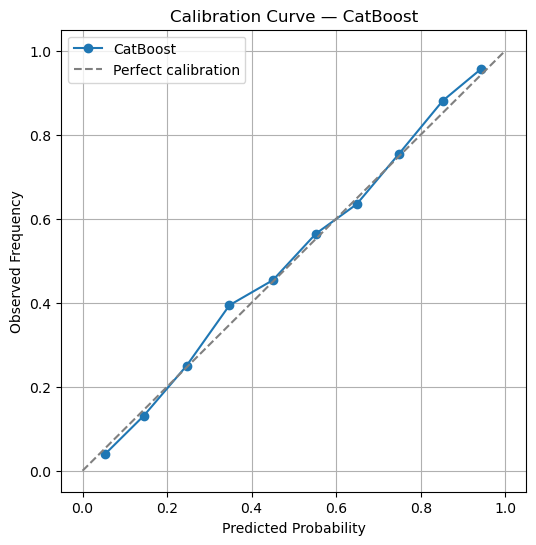

In [17]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

y_prob_final = probas[final_model_name]

prob_true, prob_pred = calibration_curve(
    y_test, y_prob_final, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label=final_model_name)
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title(f"Calibration Curve — {final_model_name}")
plt.legend()
plt.grid(True)
plt.show()


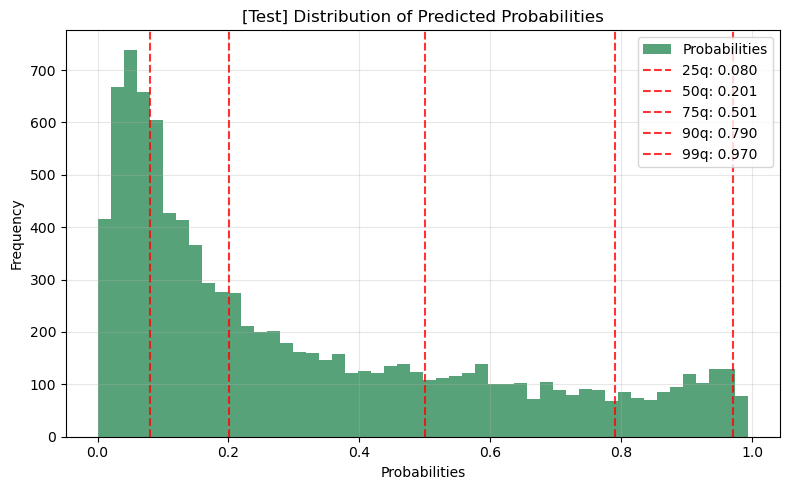

In [18]:
## QQ PLOT

import numpy as np
import matplotlib.pyplot as plt

# Probabilidades del modelo final (CatBoost)
y_prob = probas[final_model_name]

# Cuantiles a mostrar
quantiles = [0.25, 0.50, 0.75, 0.90, 0.99]
q_values = np.quantile(y_prob, quantiles)

plt.figure(figsize=(8, 5))

# Histograma
plt.hist(y_prob, bins=50, color="seagreen", alpha=0.8, label="Probabilities")

# Líneas de cuantiles
for q, v in zip(quantiles, q_values):
    plt.axvline(v, linestyle="--", color="red", alpha=0.8,
                label=f"{int(q*100)}q: {v:.3f}")

plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.title("[Test] Distribution of Predicted Probabilities")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


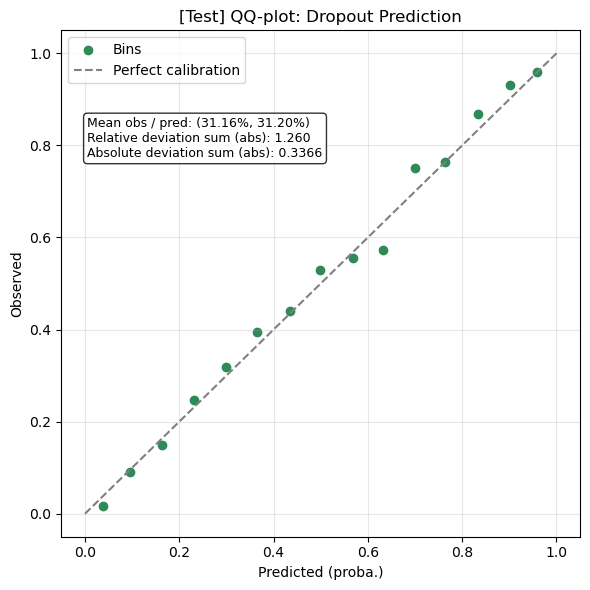

In [19]:
##CALIBRATION / QQ-PLOT (Observed vs Predicted)
from sklearn.calibration import calibration_curve

# Curva de calibración
prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=15,
    strategy="uniform"
)

# Métricas adicionales (como en la figura)
mean_obs = y_test.mean()
mean_pred = y_prob.mean()

abs_dev = np.abs(prob_true - prob_pred)
rel_dev = abs_dev / np.maximum(prob_pred, 1e-6)

plt.figure(figsize=(6, 6))

# Puntos Observed vs Predicted
plt.scatter(prob_pred, prob_true, color="seagreen", label="Bins")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")

plt.xlabel("Predicted (proba.)")
plt.ylabel("Observed")
plt.title("[Test] QQ-plot: Dropout Prediction")

# Texto informativo (como en tu imagen)
plt.text(
    0.05, 0.75,
    f"Mean obs / pred: ({mean_obs*100:.2f}%, {mean_pred*100:.2f}%)\n"
    f"Relative deviation sum (abs): {rel_dev.sum():.3f}\n"
    f"Absolute deviation sum (abs): {abs_dev.sum():.4f}",
    transform=plt.gca().transAxes,
    fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


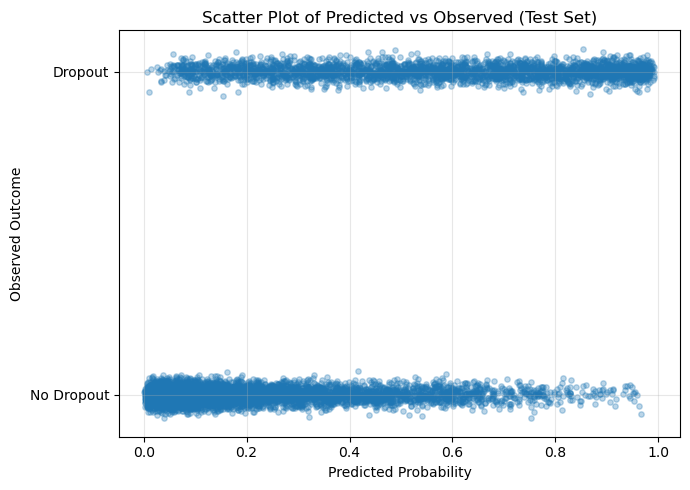

In [129]:
##SCATTER PLOT
import matplotlib.pyplot as plt
import numpy as np

# Probabilidades del modelo final
y_prob = probas[final_model_name]
y_true = y_test.values if hasattr(y_test, "values") else y_test

plt.figure(figsize=(7, 5))

# Scatter plot (jitter en Y para mejor visualización)
plt.scatter(
    y_prob,
    y_true + np.random.normal(0, 0.02, size=len(y_true)),
    alpha=0.3,
    s=15
)

plt.xlabel("Predicted Probability")
plt.ylabel("Observed Outcome")
plt.yticks([0, 1], ["No Dropout", "Dropout"])
plt.title("Scatter Plot of Predicted vs Observed (Test Set)")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



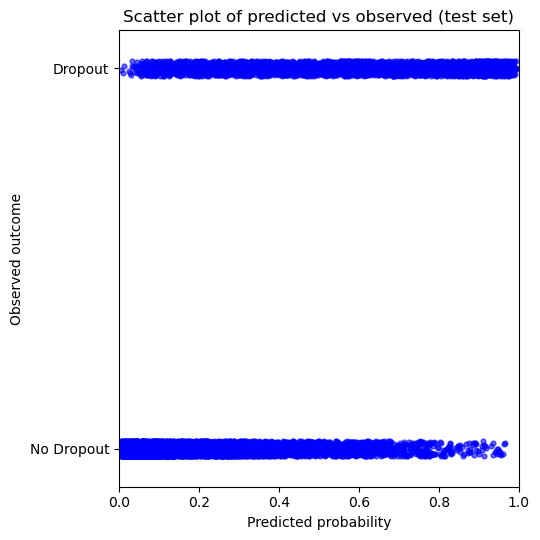

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
y_prob = probas[final_model_name]
y_true = y_test.values if hasattr(y_test, "values") else y_test

# Jitter vertical pequeño
np.random.seed(42)
y_jitter = y_true + np.random.uniform(-0.02, 0.02, size=len(y_true))

plt.figure(figsize=(5.5, 5.5))

plt.scatter(
    y_prob,
    y_jitter,
    s=12,
    alpha=0.6,          # clave para ver densidad
    color="blue"
)

plt.xlabel("Predicted probability")
plt.ylabel("Observed outcome")
plt.yticks([0, 1], ["No Dropout", "Dropout"])
plt.title("Scatter plot of predicted vs observed (test set)")

plt.xlim(0, 1)
plt.ylim(-0.1, 1.1)

plt.grid(False)
plt.tight_layout()
plt.show()


##  Estimation of DROP-OUT PROBABILITIES

In [39]:
# =============================
# DROP-OUT PROBABILITIES
# =============================

features_df["prob_dropout"] = final_model.predict_proba(X_model)[:, 1]


In [40]:
print(features_df.columns.tolist())

['id_student', 'code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits', 'dropout', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'age_band_35-55', 'age_band_55<=', 'disability_Y', 'date_registration', 'total_clicks', 'avg_clicks', 'max_clicks', 'num_interactions', 'prob_dropout']


In [41]:
# ======================================================
# GENERATE DROP-OUT PROBABILITY TABLE using the FINAL MODEL
# ======================================================

# 5. Build probability ranking table
prob_table = (
    features_df[["id_student", "prob_dropout"]]
    .reset_index(drop=True)
)

# 6. Export to Excel
output_prob_file = "Dropout_Probabilities.xlsx"
prob_table.to_excel(output_prob_file, index=False)

print("\nDropout probability table saved as:", output_prob_file)

# 7. Display 
display(prob_table)





Dropout probability table saved as: Dropout_Probabilities.xlsx


,id_student,prob_dropout
0,11391,0.558352
1,28400,0.105783
2,30268,0.550211
3,31604,0.077378
4,32885,0.214399
...,...,...
32588,2640965,0.205259
32589,2645731,0.010564
32590,2648187,0.123758
32591,2679821,0.320517


In [42]:
print(features_df.columns.tolist())

['id_student', 'code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits', 'dropout', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'age_band_35-55', 'age_band_55<=', 'disability_Y', 'date_registration', 'total_clicks', 'avg_clicks', 'max_clicks', 'num_interactions', 'prob_dropout']


## 4) XAI:Feature Importance

,Feature,RF,XGB,LGBM,CatBoost
12,Days from start,0.0302,0.0156,798,6.2178
29,Number of Interactions,0.2293,0.1358,746,22.2636
2,Average Clicks,0.1483,0.0187,692,6.3338
28,Maximum Clicks,0.1712,0.0161,624,5.9269
44,Total Clicks,0.2172,0.0220,602,13.0664
43,Credits Studied,0.0776,0.0245,400,6.3425


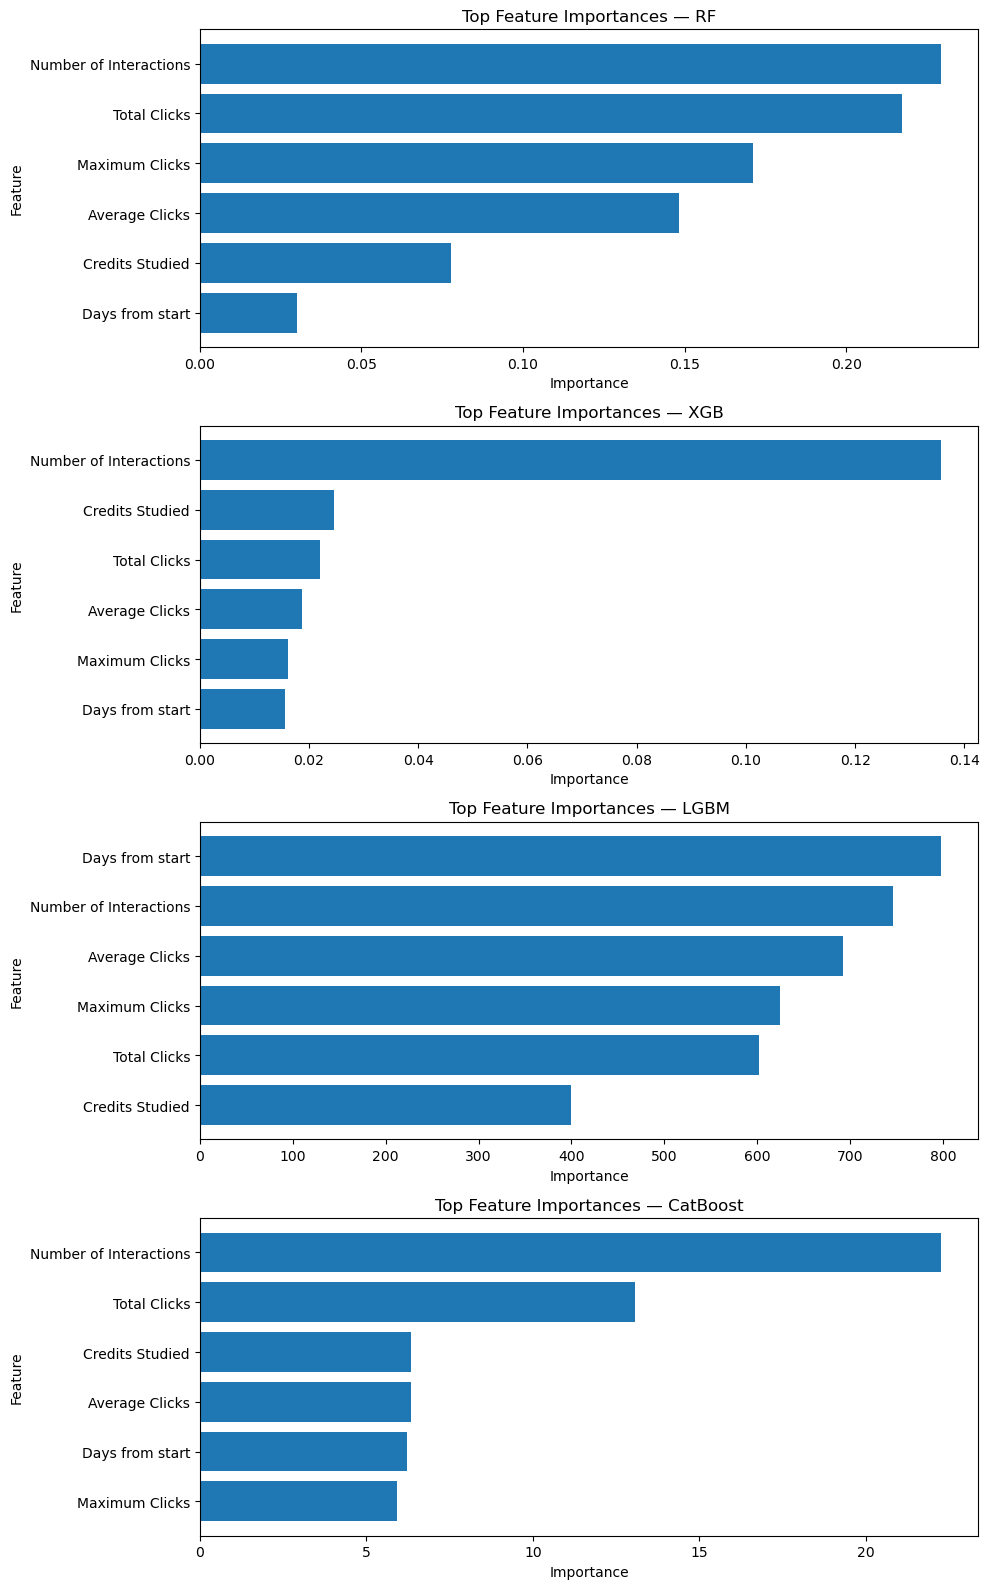

In [44]:
# =========================================
# FEATURE IMPORTANCE COMPARISON
# =========================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ------------------------------------------------------
# 0. Diccionario de nombres bonitos
# ------------------------------------------------------

pretty_names = {
    "total_clicks": "Total Clicks",
    "avg_clicks": "Average Clicks",
    "max_clicks": "Maximum Clicks",
    "num_interactions": "Number of Interactions",
    "num_of_prev_attempts": "Previous Attempts",
    "studied_credits": "Credits Studied",
    "date_registration": "Days from start",
    "gender_M": "Gender: Male",
}

# Fallback → capitalizar si no está en diccionario
def clean_name(col):
    return pretty_names.get(col, col.replace("_"," ").title())


# ------------------------------------------------------
# 1. Compute feature importance for each model
# ------------------------------------------------------

def get_importance(model, model_name):
    """Returns a dataframe with Feature + Importance for any model."""
    
    # 1. sklearn-style (.feature_importances_)
    if hasattr(model, "feature_importances_"):
        return pd.DataFrame({
            "Feature": X_train.columns,
            model_name: model.feature_importances_
        })
    
    # 2. CatBoost style
    if model_name == "CatBoost":
        try:
            imp = model.get_feature_importance()
            return pd.DataFrame({
                "Feature": X_train.columns,
                "CatBoost": imp
            })
        except:
            pass
    
    # 3. fallback
    return pd.DataFrame({
        "Feature": X_train.columns,
        model_name: [0]*len(X_train.columns)
    })


importance_tables = []

if "RandomForest" in models:
    importance_tables.append(get_importance(models["RandomForest"], "RF"))

if "XGBoost" in models:
    importance_tables.append(get_importance(models["XGBoost"], "XGB"))

if "LightGBM" in models:
    importance_tables.append(get_importance(models["LightGBM"], "LGBM"))

if "CatBoost" in models:
    importance_tables.append(get_importance(models["CatBoost"], "CatBoost"))


# ------------------------------------------------------
# 2. Merge into one comparison table
# ------------------------------------------------------
feature_importances = importance_tables[0]

for tbl in importance_tables[1:]:
    feature_importances = feature_importances.merge(tbl, on="Feature", how="outer")

feature_importances = feature_importances.fillna(0)

# ------------------------------------------------------
# 3. Compute average importance + reduce to top 6
# ------------------------------------------------------
model_cols = [c for c in feature_importances.columns if c != "Feature"]

feature_importances["Avg"] = feature_importances[model_cols].mean(axis=1)

top6 = feature_importances.sort_values("Avg", ascending=False).head(6).copy()

# ------------------------------------------------------
# 4. Clean feature names using pretty_names
# ------------------------------------------------------
top6["Feature_clean"] = top6["Feature"].apply(clean_name)

# ------------------------------------------------------
# 5. Display comparative table 
# ------------------------------------------------------
display(
    top6[["Feature_clean"] + model_cols]
        .rename(columns={"Feature_clean": "Feature"})
        .style.background_gradient(cmap="YlGnBu")
        .format(precision=4)
)

# ------------------------------------------------------
# 6. Plot individual models — horizontal barplots
# ------------------------------------------------------

fig, axes = plt.subplots(len(model_cols), 1, figsize=(10, 4*len(model_cols)))

for i, model_name in enumerate(model_cols):
    ax = axes[i]
    subset = top6.sort_values(model_name, ascending=True)  # ascending so the highest is at top visually
    ax.barh(subset["Feature_clean"], subset[model_name])
    ax.set_title(f"Top Feature Importances — {model_name}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")

plt.tight_layout()
plt.show()



## 5) XAI:SHAP global (bar)

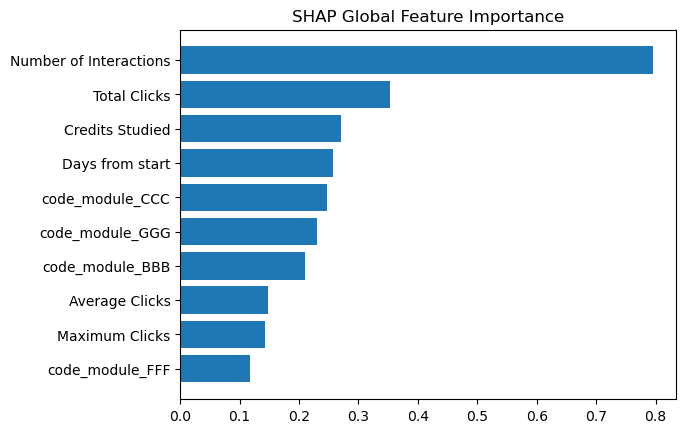

In [46]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample for SHAP
n_sample = min(1000, len(X_model))
X_sample = X_model.sample(n_sample, random_state=42)

explainer = shap.TreeExplainer(final_model)
shap_vals = explainer.shap_values(X_sample)

# Binary → positive class
if isinstance(shap_vals, list):
    shap_vals = shap_vals[-1]

# -------- BAR --------
mean_abs = np.mean(np.abs(shap_vals), axis=0)
idx = np.argsort(mean_abs)[-10:]

plt.barh(
    [pretty_names.get(X_sample.columns[i], X_sample.columns[i]) for i in idx],
    mean_abs[idx]
)
plt.title("SHAP Global Feature Importance")
plt.show()




## 6) XAI:SHAP global (Beeswarm)

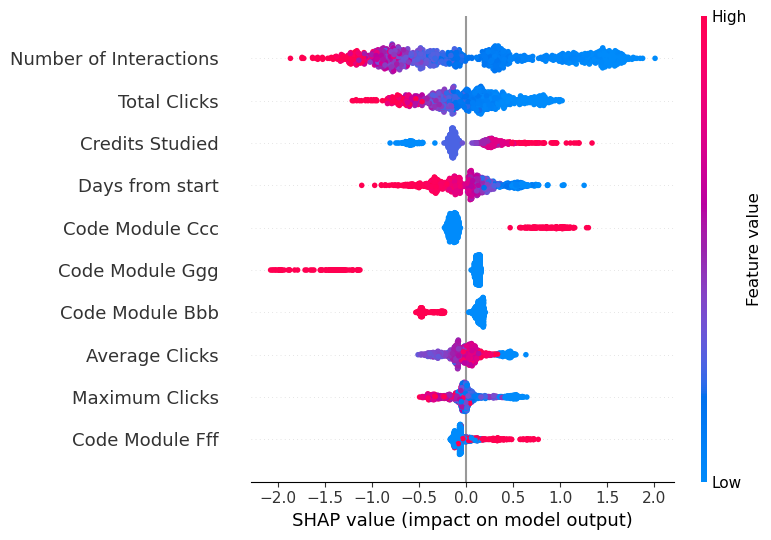

In [48]:
# -------- BEESWARM --------
shap.summary_plot(
    shap_vals,
    X_sample,
    feature_names=[
        pretty_names.get(c, c.replace("_"," ").title())
        for c in X_sample.columns
    ],
    max_display=10
)

## 7) ALE plots 

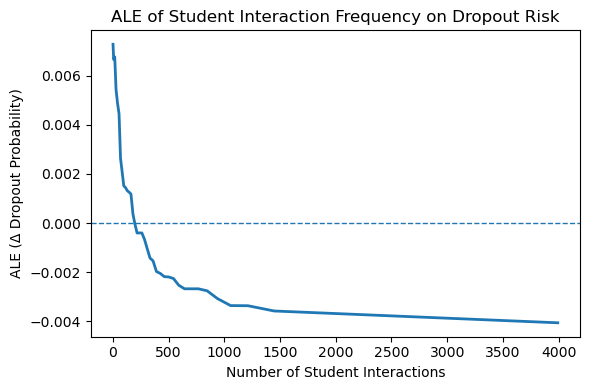

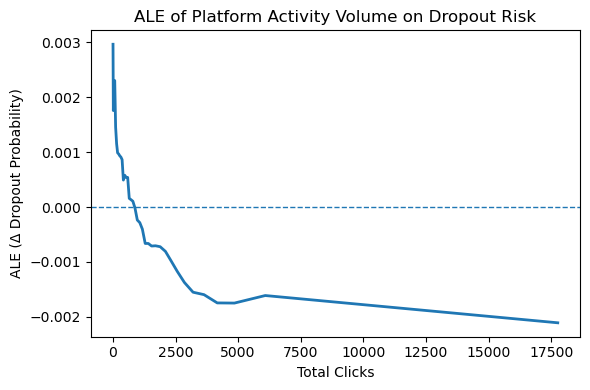

In [50]:
# =========================================
# ALE manual (1D) — Publication-ready
# =========================================

import numpy as np
import matplotlib.pyplot as plt

def ale_1d(model, X, feature, bins=40):
    """
    Compute 1D Accumulated Local Effects (ALE) for a single feature.
    """
    x = X[feature].values
    quantiles = np.quantile(x, np.linspace(0, 1, bins + 1))

    effects = []
    mids = []

    for i in range(bins):
        mask = (x >= quantiles[i]) & (x < quantiles[i + 1])
        if mask.sum() == 0:
            continue

        X_low = X.copy()
        X_high = X.copy()

        X_low.loc[mask, feature] = quantiles[i]
        X_high.loc[mask, feature] = quantiles[i + 1]

        preds = (
            model.predict_proba(X_high)[:, 1]
            - model.predict_proba(X_low)[:, 1]
        )

        effects.append(preds.mean())
        mids.append((quantiles[i] + quantiles[i + 1]) / 2)

    ale_vals = np.cumsum(effects)
    ale_vals -= np.mean(ale_vals)  # center at zero

    return mids, ale_vals


# =========================================
# Feature metadata (labels & titles)
# =========================================

feature_metadata = {
    "num_interactions": {
        "xlabel": "Number of Student Interactions",
        "title": "ALE of Student Interaction Frequency on Dropout Risk"
    },
    "total_clicks": {
        "xlabel": "Total Clicks",
        "title": "ALE of Platform Activity Volume on Dropout Risk"
    }
}

features_ale = list(feature_metadata.keys())

# =========================================
# Plot ALE (publication-ready)
# =========================================

for feature in features_ale:
    if feature not in X_model.columns:
        print(f"⚠ Feature '{feature}' not found in X_model — skipping.")
        continue

    x_vals, ale_vals = ale_1d(final_model, X_model, feature, bins=40)

    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, ale_vals, linewidth=2)
    plt.axhline(0, linestyle="--", linewidth=1)

    plt.xlabel(feature_metadata[feature]["xlabel"])
    plt.ylabel("ALE (Δ Dropout Probability)")
    plt.title(feature_metadata[feature]["title"])

    plt.tight_layout()
    plt.show()



## 8) XAI:SHAP local explanation

In [52]:
# Force plot mostrando SOLO los top-k drivers
X_model_clean = X_model.copy()
X_model_clean.columns = (
    X_model_clean.columns
    .str.replace("highest_education_Lower_Than_A_level", "Edu: ", regex=False)
    .str.replace("code_module_", "Module: ", regex=False)
    .str.replace("_", " ")
)

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_16032\406076376.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  shap.force_plot(explainer.expected_value, shap_vals[student_index][np.argsort(np.abs(shap_vals[student_index]))[-7:]], X_model_clean.iloc[student_index][np.argsort(np.abs(shap_vals[student_index]))[-7:]], matplotlib=True)


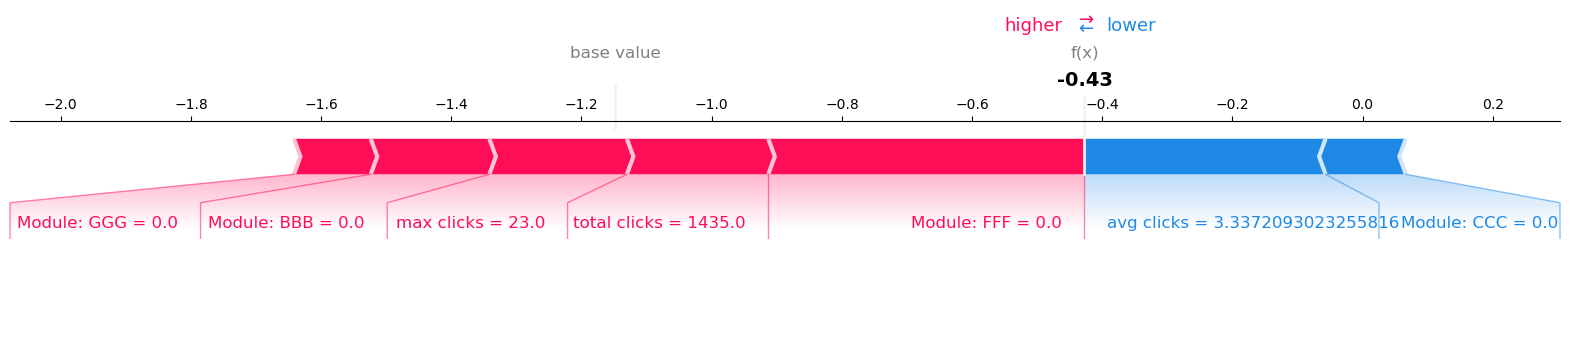

In [53]:
student_index = 1
shap.force_plot(explainer.expected_value, shap_vals[student_index][np.argsort(np.abs(shap_vals[student_index]))[-7:]], X_model_clean.iloc[student_index][np.argsort(np.abs(shap_vals[student_index]))[-7:]], matplotlib=True)


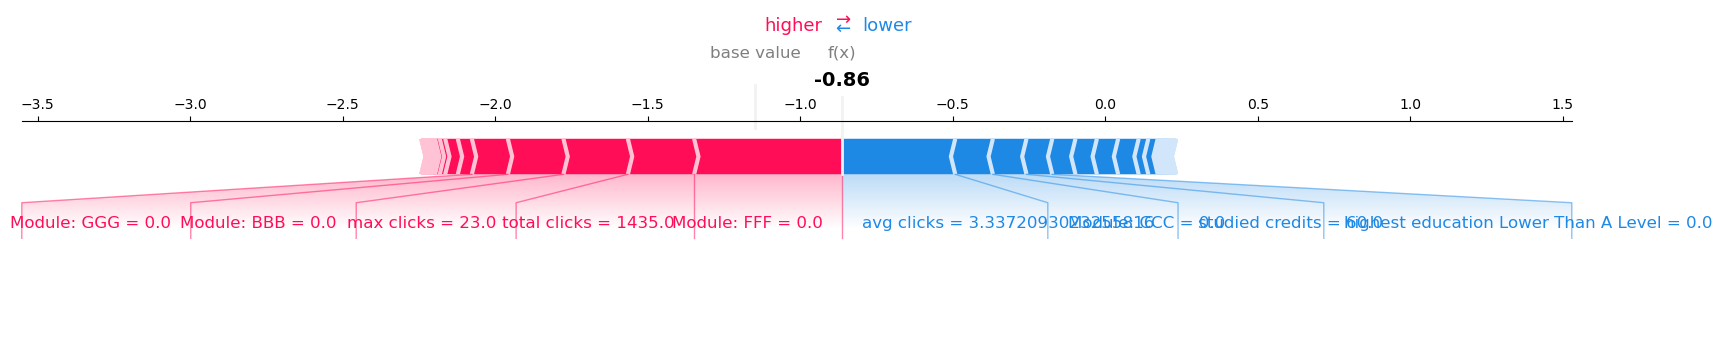

In [54]:

# Explain prediction for 2 random students
student_index = 1
shap.force_plot(
    explainer.expected_value, 
    shap_vals[student_index,:], 
    X_model_clean.iloc[student_index,:],
    matplotlib=True
)



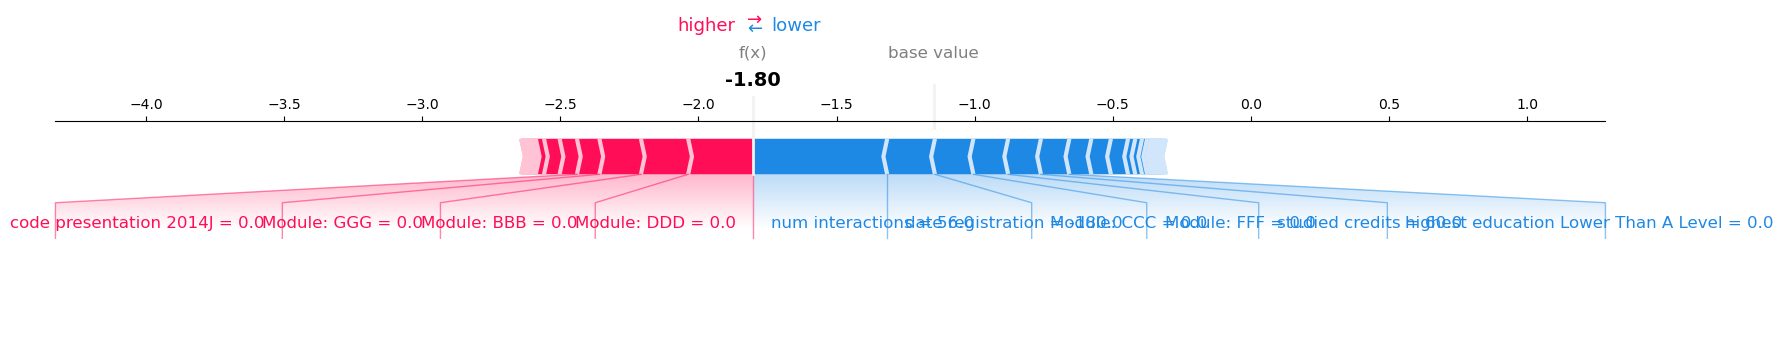

In [55]:
student_index = 15
shap.force_plot(
    explainer.expected_value, 
    shap_vals[student_index,:], 
    X_model_clean.iloc[student_index,:],
    matplotlib=True
)



## 9) PERSONALIZED RECOMMENDATION MODEL

In [57]:
# =========================================
# CatBoost+ SHAP — individual values for ALL students
# =========================================

import numpy as np
import shap

# -------------------------------------------------
# 1. Usar EXACTAMENTE el X del modelo (congelado)
# -------------------------------------------------
X_full = X_model.copy()

# -------------------------------------------------
# 2. SHAP explainer
# -------------------------------------------------
explainer = shap.TreeExplainer(final_model)
shap_vals_full = explainer.shap_values(X_full)

# Binary classification → keep positive class
if isinstance(shap_vals_full, list):
    shap_vals_full = shap_vals_full[-1]


# ============================================
# STEP 1 — SHAP impact metrics
# ============================================
# -------------------------------------------------
# Extract top SHAP drivers per student
# -------------------------------------------------
def extract_top_shap(shap_values, X_df, top_n=3):
    feature_names = X_df.columns.tolist()
    drivers = []

    for i in range(len(X_df)):
        row = shap_values[i]
        idx = np.argsort(np.abs(row))[-top_n:][::-1]

        feats = [
            f"{feature_names[j]} ({row[j]:+.3f})"
            for j in idx
        ]
        drivers.append("; ".join(feats))

    return drivers

# -------------------------------------------------
# SHAP impact metrics
# -------------------------------------------------
features_df["SHAP_Impact"] = np.abs(shap_vals_full).mean(axis=1)

features_df["SHAP_Impact_Norm"] = (
    features_df["SHAP_Impact"] - features_df["SHAP_Impact"].min()
) / (
    features_df["SHAP_Impact"].max() - features_df["SHAP_Impact"].min()
)

# -------------------------------------------------
# Main risk drivers (Top 3 per student)
# -------------------------------------------------
features_df["Main_Risk_Drivers"] = extract_top_shap(
    shap_vals_full,
    X_full,
    top_n=3
)

print(features_df.columns.tolist())


['id_student', 'code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits', 'dropout', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'age_band_35-55', 'age_band_55<=', 'disability_Y', 'date_registration', 'total_clicks', 'avg_clicks', 'max_clicks', 'num_interactions', 'prob_dropout', 'SHAP_Impact', 'SHAP_Impact_Norm', 'Main_Risk_Drivers']


In [58]:
# ============================================
# STEP 2 — Risk level
# ============================================

def risk_level(prob):
    if prob >= 0.70:
        return "High Risk"
    elif prob >= 0.40:
        return "Moderate Risk"
    else:
        return "Low Risk"

features_df["Risk_Level"] = features_df["prob_dropout"].apply(risk_level)


In [59]:
# ============================================
# STEP 3 — WHY explanation
# ============================================

def why_explanation(row):
    prob = round(row["prob_dropout"] * 100, 1)
    drivers = row["Main_Risk_Drivers"]

    return (
        f"The model estimates a {prob}% probability of dropout. "
        f"This prediction is mainly influenced by: {drivers}."
    )

features_df["WHY_Explanation"] = features_df.apply(
    why_explanation,
    axis=1
)


In [60]:
print(features_df.columns.tolist())

['id_student', 'code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits', 'dropout', 'gender_M', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'age_band_35-55', 'age_band_55<=', 'disability_Y', 'date_registration', 'total_clicks', 'avg_clicks', 'max_clicks', 'num_interactions', 'prob_dropout', 'SHAP_Impact', 'SHAP_Impact_Norm', 'Main_Risk_Drivers', 'Risk_Level', 'WHY_Explanation']


In [61]:
# ============================================
# PERSONALIZED RECOMMENDATION ENGINE ============================================

# ============================================
# DRIVER CATEGORIES (Behavior-aware)
# ============================================

driver_categories = {

    # ===============================
    # Engagement — Volume (how much)
    # ===============================
    "total_clicks": "Engagement_Volume",
    "num_interactions": "Engagement_Volume",

    # ===============================
    # Engagement — Regularity (how consistent)
    # ===============================
    "avg_clicks": "Engagement_Regularity",

    # ===============================
    # Engagement — Intensity (how concentrated)
    # ===============================
    "max_clicks": "Engagement_Intensity",

    # ===============================
    # Academic context
    # ===============================
    "num_of_prev_attempts": "Academic_History",
    "highest_education": "Educational_Background",

    # ===============================
    # Course load
    # ===============================
    "studied_credits": "Course_Load",

    # ===============================
    # Enrollment timing (post hoc, interpretative)
    # ===============================
    "date_registration": "Enrollment_Timing",

    # ===============================
    # Disability
    # ===============================
    "disability": "Disability_Declared"
}



In [62]:
# ============================================
# RISK LEVEL × DRIVER CATEGORY → ACTIONS
# ============================================

strategy_map = {

    # =====================================================
    # ENGAGEMENT — VOLUME
    # =====================================================

    ("High Risk", "Engagement_Volume"):
        "Initiate immediate outreach to increase overall participation, including mandatory academic follow-up, structured use of learning resources, and close monitoring of weekly activity levels.",

    ("Moderate Risk", "Engagement_Volume"):
        "Encourage increased participation through targeted reminders, guided use of course materials, and optional academic support sessions.",

    ("Low Risk", "Engagement_Volume"):
        "Maintain current participation levels through standard academic follow-up and periodic engagement validation.",


    # =====================================================
    # ENGAGEMENT — REGULARITY
    # =====================================================

    ("High Risk", "Engagement_Regularity"):
        "Implement structured study planning support by defining weekly routines, establishing fixed checkpoints, and providing time-management guidance.",

    ("Moderate Risk", "Engagement_Regularity"):
        "Support the development of more consistent study habits through light-touch mentoring and periodic progress reminders.",

    ("Low Risk", "Engagement_Regularity"):
        "Reinforce existing engagement patterns through positive feedback and confirmation of effective study routines.",


    # =====================================================
    # ENGAGEMENT — INTENSITY
    # =====================================================

    ("High Risk", "Engagement_Intensity"):
        "Address reactive or last-minute study behavior by providing pacing guidance, workload distribution strategies, and early assessment planning support.",

    ("Moderate Risk", "Engagement_Intensity"):
        "Encourage smoother distribution of study effort across the course timeline and promote early interaction with learning materials.",

    ("Low Risk", "Engagement_Intensity"):
        "Monitor engagement peaks to confirm sustainable study intensity and prevent future overload.",


    # =====================================================
    # ACADEMIC HISTORY
    # =====================================================

    ("High Risk", "Academic_History"):
        "Provide proactive academic advising focused on prior learning difficulties, including tutoring referrals and individualized learning plans.",

    ("Moderate Risk", "Academic_History"):
        "Offer targeted academic guidance and monitor for early signs of recurring difficulties.",

    ("Low Risk", "Academic_History"):
        "Continue standard academic monitoring to ensure previous difficulties do not re-emerge.",


    # =====================================================
    # EDUCATIONAL BACKGROUND
    # =====================================================

    ("High Risk", "Educational_Background"):
        "Provide additional academic orientation and foundational learning support tailored to the student’s prior educational background.",

    ("Moderate Risk", "Educational_Background"):
        "Monitor academic adaptation and offer support if learning gaps emerge.",

    ("Low Risk", "Educational_Background"):
        "Ensure continued access to standard academic orientation resources and self-support materials.",


    # =====================================================
    # COURSE LOAD
    # =====================================================

    ("High Risk", "Course_Load"):
        "Review and adjust course load where possible, prioritizing essential modules and aligning workload with student capacity.",

    ("Moderate Risk", "Course_Load"):
        "Assess workload balance and provide guidance on managing study commitments effectively.",

    ("Low Risk", "Course_Load"):
        "Maintain current course load and periodically validate workload sustainability.",


    # =====================================================
    # ENROLLMENT TIMING (POST HOC)
    # =====================================================

    ("High Risk", "Enrollment_Timing"):
        "Strengthen early-course academic orientation and clarify expectations to support smoother adaptation.",

    ("Moderate Risk", "Enrollment_Timing"):
        "Provide additional guidance during initial course phases to support adjustment.",

    ("Low Risk", "Enrollment_Timing"):
        "Confirm that standard academic orientation was sufficient and no additional onboarding support is required.",


# =====================================================
# DISABILITY (online learning context, post hoc)
# =====================================================

("High Risk", "Disability_Declared"):
    "Review whether digital learning materials, assessments, and platform interactions are accessible and sufficiently flexible. "
    "Provide clearer structure, explicit instructions, and guided study pathways to reduce potential interaction or cognitive barriers.",

("Moderate Risk", "Disability_Declared"):
    "Monitor interaction patterns for signs of accessibility-related friction. "
    "Ensure learning resources are clearly organized, navigation is intuitive, and support channels are visible if needed.",

("Low Risk", "Disability_Declared"):
    "Maintain inclusive digital design and accessible learning materials. "
    "No targeted intervention is required beyond routine monitoring."

}



In [63]:
# ============================================
# PRIORITIZED ACTION SELECTION
# ============================================

def parse_shap_drivers(driver_string):
    """
    Parse strings like:
    'registration_gap (+1.710); studied_credits (+1.244)'
    into: [('registration_gap', 1.710), ('studied_credits', 1.244)]
    """
    parsed = []
    for d in driver_string.split(";"):
        d = d.strip()
        if "(" in d and ")" in d:
            name, val = d.rsplit("(", 1)
            try:
                val = float(val.replace(")", "").strip())
                parsed.append((name.strip(), val))
            except:
                continue
    return parsed

def prioritized_recommendation(row, max_actions=3):
    """
    Generate prioritized, action-oriented recommendations
    based on positive SHAP drivers and risk level.
    """

    risk = row["Risk_Level"]
    drivers_raw = row["Main_Risk_Drivers"]

    parsed_drivers = parse_shap_drivers(drivers_raw)

    # --------------------------------------------------
    # Keep only positive SHAP drivers (risk-increasing)
    # --------------------------------------------------
    positive_drivers = [
        (feat, val) for feat, val in parsed_drivers if val > 0
    ]

    # If no positive drivers → fallback
    if not positive_drivers:
        if risk == "High Risk":
            return (
                "High predicted dropout risk with no dominant risk drivers. "
                "Recommend general academic monitoring and regular advisor follow-up."
            )
        elif risk == "Moderate Risk":
            return (
                "Moderate dropout risk with no dominant risk drivers. "
                "Recommend continued monitoring and optional academic support."
            )
        else:
            return (
                "Low predicted dropout risk. "
                "Continue routine academic monitoring."
            )

    # --------------------------------------------------
    # Sort drivers by SHAP magnitude (descending)
    # --------------------------------------------------
    positive_drivers = sorted(
        positive_drivers,
        key=lambda x: abs(x[1]),
        reverse=True
    )

    selected_actions = []
    used_categories = set()

    # --------------------------------------------------
    # Map drivers → categories → strategies
    # --------------------------------------------------
    for feat, val in positive_drivers:

        for prefix, category in driver_categories.items():
            if feat.startswith(prefix):

                # Avoid duplicate categories
                if category in used_categories:
                    continue

                key = (risk, category)
                if key in strategy_map:
                    selected_actions.append(strategy_map[key])
                    used_categories.add(category)

                break

        # Stop when enough actions collected
        if len(selected_actions) >= max_actions:
            break

    # --------------------------------------------------
    # Final safety fallback
    # --------------------------------------------------
    if not selected_actions:
        return (
            "Predicted dropout risk identified, but no actionable drivers were detected. "
            "Recommend routine academic monitoring."
        )

    return " ".join(selected_actions)


# ============================================
# GENERATE FINAL COLUMN
# ============================================

features_df["Personalized_Recommendation"] = features_df.apply(
    prioritized_recommendation,
    axis=1
)

# Quick validation
features_df[[
    "Risk_Level",
    "Main_Risk_Drivers",
    "Personalized_Recommendation"
]].head()


,Risk_Level,Main_Risk_Drivers,Personalized_Recommendation
0,Moderate Risk,studied_credits (+1.287); date_registration (+...,Assess workload balance and provide guidance o...
1,Low Risk,num_interactions (-0.610); total_clicks (-0.20...,Low predicted dropout risk. Continue routine a...
2,Moderate Risk,num_interactions (+0.570); disability_Y (+0.41...,Encourage increased participation through targ...
3,Low Risk,num_interactions (-0.854); total_clicks (-0.31...,"Predicted dropout risk identified, but no acti..."
4,Low Risk,date_registration (+0.612); num_interactions (...,Confirm that standard academic orientation was...


In [64]:
display(features_df.round(3))

,id_student,code_module,code_presentation,num_of_prev_attempts,studied_credits,dropout,gender_M,region_East Midlands Region,region_Ireland,region_London Region,...,avg_clicks,max_clicks,num_interactions,prob_dropout,SHAP_Impact,SHAP_Impact_Norm,Main_Risk_Drivers,Risk_Level,WHY_Explanation,Personalized_Recommendation
0,11391,AAA,2013J,0,240,0,True,False,False,False,...,4.765,76.0,196.0,0.558,0.077,0.309,studied_credits (+1.287); date_registration (+...,Moderate Risk,The model estimates a 55.8% probability of dro...,Assess workload balance and provide guidance o...
1,28400,AAA,2013J,0,60,0,False,False,False,False,...,3.337,23.0,430.0,0.106,0.057,0.178,num_interactions (-0.610); total_clicks (-0.20...,Low Risk,The model estimates a 10.6% probability of dro...,Low predicted dropout risk. Continue routine a...
2,30268,AAA,2013J,0,60,1,False,False,False,False,...,3.697,23.0,76.0,0.550,0.063,0.218,num_interactions (+0.570); disability_Y (+0.41...,Moderate Risk,The model estimates a 55.0% probability of dro...,Encourage increased participation through targ...
3,31604,AAA,2013J,0,60,0,False,False,False,False,...,3.255,22.0,663.0,0.077,0.061,0.206,num_interactions (-0.854); total_clicks (-0.31...,Low Risk,The model estimates a 7.7% probability of drop...,"Predicted dropout risk identified, but no acti..."
4,32885,AAA,2013J,0,60,0,False,False,False,False,...,2.938,22.0,352.0,0.214,0.060,0.199,date_registration (+0.612); num_interactions (...,Low Risk,The model estimates a 21.4% probability of dro...,Confirm that standard academic orientation was...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,2640965,GGG,2014J,0,30,0,False,False,False,False,...,2.158,11.0,19.0,0.205,0.131,0.676,num_interactions (+1.703); code_module_GGG (-1...,Low Risk,The model estimates a 20.5% probability of dro...,Maintain current participation levels through ...
32589,2645731,GGG,2014J,0,30,0,False,False,False,False,...,3.768,34.0,237.0,0.011,0.101,0.474,code_module_GGG (-1.954); studied_credits (-0....,Low Risk,The model estimates a 1.1% probability of drop...,Low predicted dropout risk. Continue routine a...
32590,2648187,GGG,2014J,0,30,0,False,False,False,False,...,2.889,23.0,108.0,0.124,0.096,0.441,code_module_GGG (-1.385); studied_credits (-0....,Low Risk,The model estimates a 12.4% probability of dro...,Maintain current participation levels through ...
32591,2679821,GGG,2014J,0,30,1,False,False,False,False,...,4.508,24.0,61.0,0.321,0.111,0.539,num_interactions (+1.340); code_module_GGG (-1...,Low Risk,The model estimates a 32.1% probability of dro...,Maintain current participation levels through ...


In [65]:
# =========================================
# Export to Excel- SIN NOMBRES BONITOS
# =========================================

features_df.to_excel(
    "PRE_XAI_Final_Personalized_Recommendations_OULAD.xlsx",
    index=False
)

print(" Personalized recommendation model completed- VERSIÓN EN BRUTO.")



 Personalized recommendation model completed- VERSIÓN EN BRUTO.


## 11) EVALUATE THE MODEL RESULTS

In [67]:
# ============================================
# EXPLODE DE RECOMENDACIONES (SIN DUPLICADOS)
# ============================================

# Crear columna de estrategias individuales
interventions_long = (
    features_df[["id_student", "Risk_Level", "Personalized_Recommendation"]]
    .assign(
        Strategy=lambda df: df["Personalized_Recommendation"]
        .str.split(r"\.\s+")
    )
    .explode("Strategy")
)

# Limpiar espacios y eliminar entradas vacías
interventions_long["Strategy"] = interventions_long["Strategy"].str.strip()
interventions_long = interventions_long[
    interventions_long["Strategy"] != ""
]

# Eliminar duplicados exactos (por estudiante)
interventions_long = interventions_long.drop_duplicates(
    subset=["id_student", "Strategy"]
)

# ============================================
# VER SALIDA Y RESUMEN
# ============================================

# Número de estrategias únicas
print("Unique strategies:", interventions_long["Strategy"].nunique())

# Total filas después del explode
print("Total rows after explode:", len(interventions_long))

# Top estrategias (sanity check)
strategy_counts = interventions_long["Strategy"].value_counts()
print(strategy_counts.head(10))

# Tabla con porcentaje sobre total de estudiantes
strategy_table = (
    strategy_counts
    .to_frame(name="Students")
    .assign(
        Percent=lambda df: 100 * df["Students"] / len(features_df)
    )
)

display(strategy_table)


Unique strategies: 51
Total rows after explode: 49996
Strategy
Low predicted dropout risk                                                                                                                                                                     7155
Continue routine academic monitoring.                                                                                                                                                          7155
Maintain current participation levels through standard academic follow-up and periodic engagement validation.                                                                                  3978
Predicted dropout risk identified, but no actionable drivers were detected                                                                                                                     3542
Recommend routine academic monitoring.                                                                                                                   

,Students,Percent
Strategy,,
Low predicted dropout risk,7155,21.952567
Continue routine academic monitoring.,7155,21.952567
Maintain current participation levels through standard academic follow-up and periodic engagement validation.,3978,12.205075
"Predicted dropout risk identified, but no actionable drivers were detected",3542,10.867364
Recommend routine academic monitoring.,3542,10.867364
"Initiate immediate outreach to increase overall participation, including mandatory academic follow-up, structured use of learning resources, and close monitoring of weekly activity levels",3024,9.278066
"Encourage increased participation through targeted reminders, guided use of course materials, and optional academic support sessions.",2856,8.762618
Maintain current course load and periodically validate workload sustainability.,2720,8.345350
Confirm that standard academic orientation was sufficient and no additional onboarding support is required.,2642,8.106035


In [68]:
# ============================================
# AUDIT 1 — DISTRIBUTION OF INTERVENTION TYPES
# ============================================

interventions_long = (
    features_df[["id_student", "Risk_Level", "Personalized_Recommendation"]]
    .assign(
        Strategy=lambda df: df["Personalized_Recommendation"].str.split(". ")
    )
    .explode("Strategy")
)

# Limpiar texto
interventions_long["Strategy"] = interventions_long["Strategy"].str.strip()
interventions_long = interventions_long[interventions_long["Strategy"] != ""]




In [69]:
redundancy_by_risk = (
    features_df
    .groupby("Risk_Level")["Personalized_Recommendation"]
    .nunique()
    .rename("Unique_Recommendations")
)

redundancy_by_risk


Risk_Level
High Risk        47
Low Risk         45
Moderate Risk    62
Name: Unique_Recommendations, dtype: int64

In [70]:
# ============================================
# TOP SHAP DRIVERS POR TIPO DE RIESGO
# ============================================

from collections import defaultdict

# Parse drivers positivos
def get_positive_drivers(driver_string):
    parsed = []
    for d in driver_string.split(";"):
        d = d.strip()
        if "(" in d and ")" in d:
            name, val = d.rsplit("(", 1)
            try:
                val = float(val.replace(")", "").strip())
                if val > 0:  # solo positivos
                    parsed.append(name.strip())
            except:
                continue
    return parsed

# Crear lista de drivers positivos por fila
features_df["Positive_Drivers"] = features_df["Main_Risk_Drivers"].apply(get_positive_drivers)

# Contar frecuencias por tipo de riesgo
risk_driver_counts = defaultdict(lambda: defaultdict(int))

for _, row in features_df.iterrows():
    risk = row["Risk_Level"]
    for driver in row["Positive_Drivers"]:
        risk_driver_counts[risk][driver] += 1

# Convertir a DataFrame
top_drivers_list = []

for risk, driver_dict in risk_driver_counts.items():
    for driver, count in driver_dict.items():
        top_drivers_list.append({"Risk_Level": risk, "Driver": driver, "Count": count})

top_drivers_df = pd.DataFrame(top_drivers_list)

# Mostrar top 5 drivers por riesgo
top_drivers_df.sort_values(["Risk_Level", "Count"], ascending=[True, False], inplace=True)
display(top_drivers_df.groupby("Risk_Level").head(5))


,Risk_Level,Driver,Count
45,High Risk,num_interactions,4354
47,High Risk,total_clicks,3704
50,High Risk,max_clicks,1569
46,High Risk,studied_credits,1129
53,High Risk,code_module_CCC,793
29,Low Risk,num_interactions,4336
23,Low Risk,date_registration,3355
25,Low Risk,studied_credits,3231
39,Low Risk,code_module_CCC,2243
31,Low Risk,total_clicks,1398


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_16032\477485493.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, "Count"))
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\MSI Prestige\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same eff

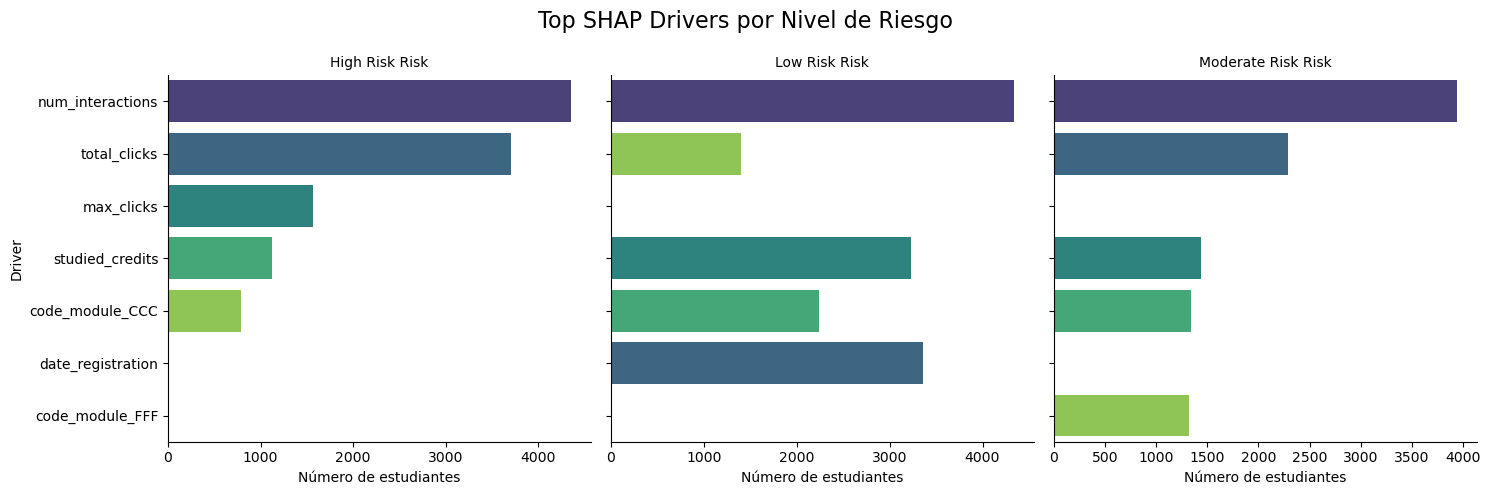

In [71]:
# ============================================
# FACET GRID: TOP SHAP DRIVERS POR RIESGO
# ============================================

import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar top 5 drivers por riesgo
top5_drivers = (
    top_drivers_df.groupby("Risk_Level")
    .apply(lambda x: x.nlargest(5, "Count"))
    .reset_index(drop=True)
)

# Crear facet grid
g = sns.FacetGrid(
    top5_drivers,
    col="Risk_Level",
    sharex=False,
    height=5,
    aspect=1
)

g.map_dataframe(
    sns.barplot,
    x="Count",
    y="Driver",
    palette="viridis",
    orient="h"
)

g.set_axis_labels("Número de estudiantes", "Driver")
g.set_titles(col_template="{col_name} Risk")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Top SHAP Drivers por Nivel de Riesgo", fontsize=16)

plt.show()


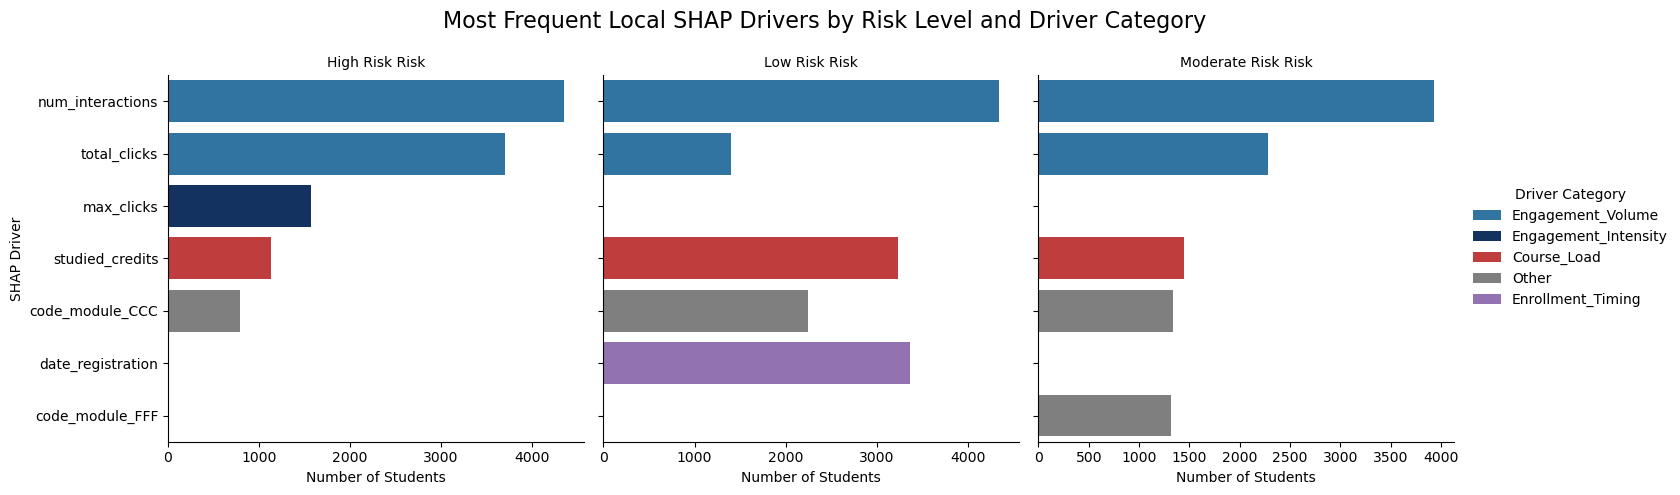

In [72]:
# ============================================
# FACET GRID: TOP SHAP DRIVERS POR RIESGO + COLOR POR CATEGORÍA
# ============================================

# ============================================
# MAPEAR CATEGORÍA DE CADA DRIVER (PREFIX-BASED)
# ============================================

def map_driver_category(driver):
    for prefix, cat in driver_categories.items():
        if driver.startswith(prefix):
            return cat
    return "Other"

top5_drivers["Category"] = top5_drivers["Driver"].apply(map_driver_category)


# ============================================
# PALETA DE COLORES POR CATEGORÍA (ACTUALIZADA)
# ============================================

palette = {
    "Engagement_Volume": "#1f77b4",
    "Engagement_Regularity": "#aec7e8",
    "Engagement_Intensity": "#08306b",
    "Academic_History": "#ff7f0e",
    "Educational_Background": "#2ca02c",
    "Course_Load": "#d62728",
    "Enrollment_Timing": "#9467bd",
    "Program_Context": "#8c564b",
    "Accessibility": "#e377c2",
    "Other": "#7f7f7f"
}

# ============================================
# FACET GRID: TOP SHAP DRIVERS POR RIESGO
# ============================================

g = sns.FacetGrid(
    top5_drivers,
    col="Risk_Level",
    sharex=False,
    height=5,
    aspect=1
)

g.map_dataframe(
    sns.barplot,
    x="Count",
    y="Driver",
    hue="Category",
    palette=palette,
    dodge=False,
    orient="h"
)

g.set_axis_labels("Number of Students", "SHAP Driver")
g.set_titles(col_template="{col_name} Risk")
g.add_legend(title="Driver Category")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle(
    "Most Frequent Local SHAP Drivers by Risk Level and Driver Category",
    fontsize=16
)

plt.show()



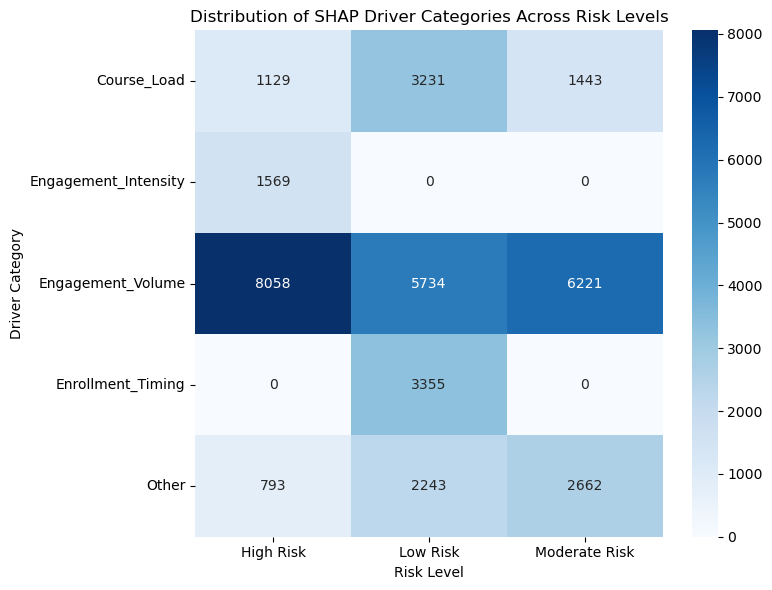

In [73]:
## MATRIZ DRIVERS-RISK (HEATMAP)
driver_risk_matrix = (
    top5_drivers
    .groupby(["Risk_Level", "Category"])["Count"]
    .sum()
    .reset_index()
    .pivot(index="Category", columns="Risk_Level", values="Count")
    .fillna(0)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    driver_risk_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues"
)

plt.title("Distribution of SHAP Driver Categories Across Risk Levels")
plt.xlabel("Risk Level")
plt.ylabel("Driver Category")
plt.tight_layout()
plt.show()


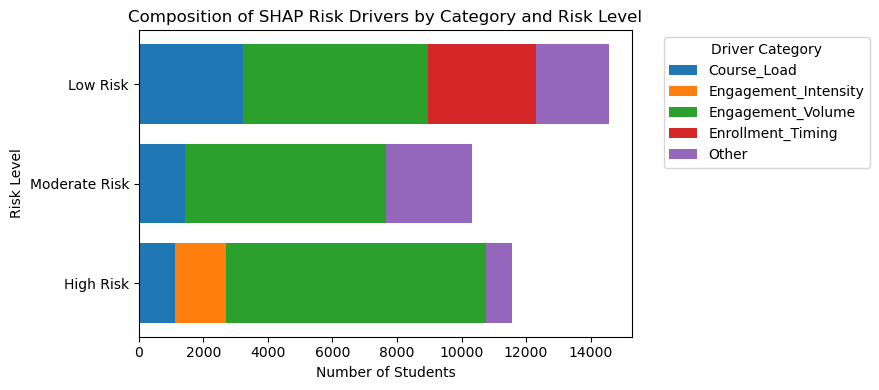

In [74]:
### BARRAS APILADAS
import matplotlib.pyplot as plt

# Pivot table: Risk_Level × Category
pivot_df = (
    top5_drivers
    .groupby(["Risk_Level", "Category"])["Count"]
    .sum()
    .unstack(fill_value=0)
)

# Orden de riesgo
risk_order = ["High Risk", "Moderate Risk", "Low Risk"]
pivot_df = pivot_df.loc[risk_order]

# Plot
fig, ax = plt.subplots(figsize=(9, 4))

left = [0] * len(pivot_df)

for category in pivot_df.columns:
    ax.barh(
        pivot_df.index,
        pivot_df[category],
        left=left,
        label=category
    )
    left = left + pivot_df[category].values

ax.set_xlabel("Number of Students")
ax.set_ylabel("Risk Level")
ax.set_title("Composition of SHAP Risk Drivers by Category and Risk Level")
ax.legend(title="Driver Category", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


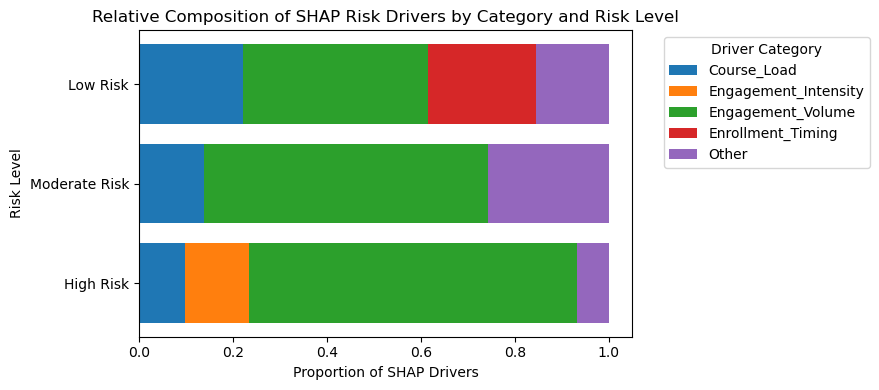

In [75]:
import matplotlib.pyplot as plt

# ============================================
# Pivot: Risk_Level × Category
# ============================================

pivot_df = (
    top5_drivers
    .groupby(["Risk_Level", "Category"])["Count"]
    .sum()
    .unstack(fill_value=0)
)

# 🔴 ORDEN CORRECTO PARA EL PAPER
risk_order = ["High Risk", "Moderate Risk", "Low Risk"]
pivot_df = pivot_df.loc[risk_order]

# ============================================
# Convert to proportions (100% stacked)
# ============================================

pivot_prop = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# ============================================
# Plot
# ============================================

fig, ax = plt.subplots(figsize=(9, 4))

left = [0] * len(pivot_prop)

for category in pivot_prop.columns:
    ax.barh(
        pivot_prop.index,
        pivot_prop[category],
        left=left,
        label=category
    )
    left = left + pivot_prop[category].values

ax.set_xlabel("Proportion of SHAP Drivers")
ax.set_ylabel("Risk Level")
ax.set_title("Relative Composition of SHAP Risk Drivers by Category and Risk Level")

ax.legend(
    title="Driver Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()



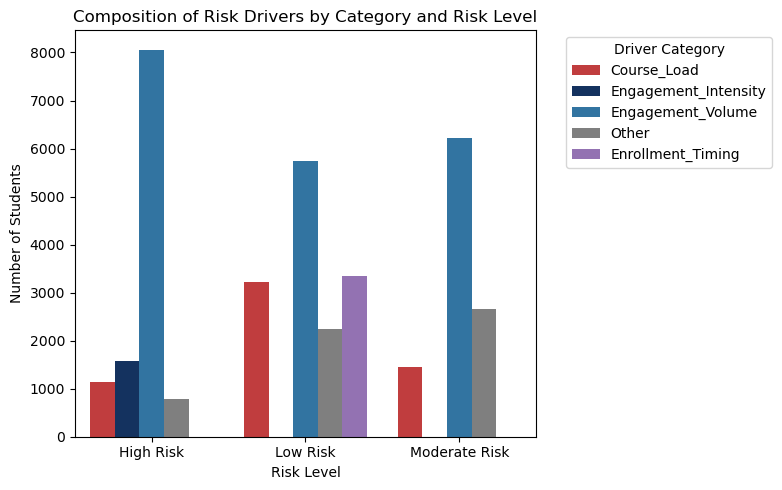

In [76]:


stacked = (
    top5_drivers
    .groupby(["Risk_Level", "Category"])["Count"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=stacked,
    x="Risk_Level",
    y="Count",
    hue="Category",
    palette=palette
)

plt.title("Composition of Risk Drivers by Category and Risk Level")
plt.ylabel("Number of Students")
plt.xlabel("Risk Level")
plt.legend(title="Driver Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [77]:
###

features_df["Primary_Driver_Category"] = (
    features_df["Main_Risk_Drivers"]
    .str.split(";")
    .str[0]
    .apply(map_driver_category)
)

action_summary = (
    features_df
    .groupby(["Risk_Level", "Primary_Driver_Category"])
    .size()
    .reset_index(name="Students")
)

action_summary



,Risk_Level,Primary_Driver_Category,Students
0,High Risk,Course_Load,164
1,High Risk,Disability_Declared,1
2,High Risk,Engagement_Volume,4105
3,High Risk,Enrollment_Timing,52
4,High Risk,Other,248
5,Low Risk,Academic_History,5
6,Low Risk,Course_Load,827
7,Low Risk,Disability_Declared,74
8,Low Risk,Educational_Background,4
9,Low Risk,Engagement_Intensity,245


## 12) CHANGE LABELs AND FORMAT RESULTS

In [79]:
# =========================================
# Convert booleans to 0/1 (safety step)
# =========================================

for col in features_df.columns:
    if features_df[col].dtype == bool:
        features_df[col] = features_df[col].astype(int)

# =========================================
# Rename columns (FULL, presentation-ready)
# =========================================

rename_dict = {

    # -----------------------
    # Identifiers & course
    # -----------------------
    "id_student": "Student_ID",
    "code_module": "Module",
    "code_presentation": "Semester Module",

    # -----------------------
    # Academic background
    # -----------------------
    "num_of_prev_attempts": "Previous_Attempts",
    "studied_credits": "Studied_Credits",

    # -----------------------
    # Target
    # -----------------------
    "dropout": "Dropout_Label",

    # -----------------------
    # Demographics
    # -----------------------
    "gender_M": "Gender_Male",

    "age_band_35-55": "Age_35_55",
    "age_band_55<=": "Age_55_Plus",

    "disability_Y": "Disability",

    # -----------------------
    # Socioeconomic (IMD)
    # -----------------------
    "imd_band_10-20": "IMD_10_20",
    "imd_band_20-30%": "IMD_20_30",
    "imd_band_30-40%": "IMD_30_40",
    "imd_band_40-50%": "IMD_40_50",
    "imd_band_50-60%": "IMD_50_60",
    "imd_band_60-70%": "IMD_60_70",
    "imd_band_70-80%": "IMD_70_80",
    "imd_band_80-90%": "IMD_80_90",
    "imd_band_90-100%": "IMD_90_100",

    # -----------------------
    # Education level
    # -----------------------
    "highest_education_HE Qualification": "Education_HE",
    "highest_education_Lower Than A Level": "Education_Lower_A_Level",
    "highest_education_No Formal quals": "Education_No_Formal",
    "highest_education_Post Graduate Qualification": "Education_Postgraduate",

    # -----------------------
    # Region (one-hot)
    # -----------------------
    "region_East Midlands Region": "Region_East_Midlands",
    "region_Ireland": "Region_Ireland",
    "region_London Region": "Region_London",
    "region_North Region": "Region_North",
    "region_North Western Region": "Region_North_West",
    "region_Scotland": "Region_Scotland",
    "region_South East Region": "Region_South_East",
    "region_South Region": "Region_South",
    "region_South West Region": "Region_South_West",
    "region_Wales": "Region_Wales",
    "region_West Midlands Region": "Region_West_Midlands",
    "region_Yorkshire Region": "Region_Yorkshire",

    # -----------------------
    # Registration / timing
    # -----------------------
    "date_registration": "Days from start",
    
    # -----------------------
    # Engagement metrics
    # -----------------------
    "total_clicks": "Total Clicks",
    "avg_clicks": "Average Clicks",
    "max_clicks": "Max_Clicks",
    "num_interactions": "Number of Interactions",

       # -----------------------
    # Model outputs
    # -----------------------
    "prob_dropout": "Dropout_Probability",
   
}

# Apply renaming
features_df = features_df.rename(columns=rename_dict)

display(features_df.round(3))


,Student_ID,Module,Semester Module,Previous_Attempts,Studied_Credits,Dropout_Label,Gender_Male,Region_East_Midlands,Region_Ireland,Region_London,...,Number of Interactions,Dropout_Probability,SHAP_Impact,SHAP_Impact_Norm,Main_Risk_Drivers,Risk_Level,WHY_Explanation,Personalized_Recommendation,Positive_Drivers,Primary_Driver_Category
0,11391,AAA,2013J,0,240,0,1,0,0,0,...,196.0,0.558,0.077,0.309,studied_credits (+1.287); date_registration (+...,Moderate Risk,The model estimates a 55.8% probability of dro...,Assess workload balance and provide guidance o...,"[studied_credits, date_registration]",Course_Load
1,28400,AAA,2013J,0,60,0,0,0,0,0,...,430.0,0.106,0.057,0.178,num_interactions (-0.610); total_clicks (-0.20...,Low Risk,The model estimates a 10.6% probability of dro...,Low predicted dropout risk. Continue routine a...,[],Engagement_Volume
2,30268,AAA,2013J,0,60,1,0,0,0,0,...,76.0,0.550,0.063,0.218,num_interactions (+0.570); disability_Y (+0.41...,Moderate Risk,The model estimates a 55.0% probability of dro...,Encourage increased participation through targ...,"[num_interactions, disability_Y, age_band_35-55]",Engagement_Volume
3,31604,AAA,2013J,0,60,0,0,0,0,0,...,663.0,0.077,0.061,0.206,num_interactions (-0.854); total_clicks (-0.31...,Low Risk,The model estimates a 7.7% probability of drop...,"Predicted dropout risk identified, but no acti...",[age_band_35-55],Engagement_Volume
4,32885,AAA,2013J,0,60,0,0,0,0,0,...,352.0,0.214,0.060,0.199,date_registration (+0.612); num_interactions (...,Low Risk,The model estimates a 21.4% probability of dro...,Confirm that standard academic orientation was...,"[date_registration, highest_education_Lower_Th...",Enrollment_Timing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,2640965,GGG,2014J,0,30,0,0,0,0,0,...,19.0,0.205,0.131,0.676,num_interactions (+1.703); code_module_GGG (-1...,Low Risk,The model estimates a 20.5% probability of dro...,Maintain current participation levels through ...,"[num_interactions, total_clicks]",Engagement_Volume
32589,2645731,GGG,2014J,0,30,0,0,0,0,0,...,237.0,0.011,0.101,0.474,code_module_GGG (-1.954); studied_credits (-0....,Low Risk,The model estimates a 1.1% probability of drop...,Low predicted dropout risk. Continue routine a...,[],Other
32590,2648187,GGG,2014J,0,30,0,0,0,0,0,...,108.0,0.124,0.096,0.441,code_module_GGG (-1.385); studied_credits (-0....,Low Risk,The model estimates a 12.4% probability of dro...,Maintain current participation levels through ...,[num_interactions],Other
32591,2679821,GGG,2014J,0,30,1,0,0,0,0,...,61.0,0.321,0.111,0.539,num_interactions (+1.340); code_module_GGG (-1...,Low Risk,The model estimates a 32.1% probability of dro...,Maintain current participation levels through ...,[num_interactions],Engagement_Volume


In [80]:
# =========================================
# Export to Excel
# =========================================

features_df.to_excel(
    "XAI_Final_Personalized_Recommendations_OULAD.xlsx",
    index=False
)

print(" Personalized recommendation model completed.")



 Personalized recommendation model completed.


## 13) METRICS FROM THE RECOMMENDATION MODEL

In [82]:
# =========================================
#Transform student interaction data into actionable early-warning insights at cohort, program and institutional level.
# =========================================

summary_exec = pd.DataFrame({
    "Metric": [
        "Total students analyzed",
        "Average dropout risk",
        "High-risk students (≥70%)",
        "Medium-risk students (40–70%)",
        "Low-risk students (<40%)",
    ],
    "Value": [
        len(features_df),
        f"{features_df['Dropout_Probability'].mean():.1%}",
        (features_df['Dropout_Probability'] >= 0.70).sum(),
        ((features_df['Dropout_Probability'] >= 0.40) & 
         (features_df['Dropout_Probability'] < 0.70)).sum(),
        (features_df['Dropout_Probability'] < 0.40).sum()
    ]
})

summary_exec

# Executive Summary Table:
#Qué responde: ¿Qué tan grave es el problema?, ¿Dónde está concentrado?, ¿Cuántos estudiantes requieren acción inmediata?


,Metric,Value
0,Total students analyzed,32593
1,Average dropout risk,31.2%
2,High-risk students (≥70%),4570
3,Medium-risk students (40–70%),5731
4,Low-risk students (<40%),22292


In [83]:
#Impact Simulation (WHAT-IF)
#“What happens if we reduce dropout risk by just 10% in high-risk students?”

baseline_dropout = features_df["Dropout_Probability"].sum()

simulated_dropout = (
    features_df
    .assign(
        prob_sim=lambda df: np.where(
            df["Dropout_Probability"] >= 0.7,
            df["Dropout_Probability"] * 0.9,  # 10% reduction
            df["Dropout_Probability"]
        )
    )["prob_sim"].sum()
)

impact = baseline_dropout - simulated_dropout

impact_rounded = round(impact)

print(
    f"A modest 10% risk reduction in high-risk students could prevent "
    f"approximately {impact_rounded} student dropouts per semester."
)


A modest 10% risk reduction in high-risk students could prevent approximately 392 student dropouts per semester.


In [84]:
#Program-level Risk (para decisiones académicas)
module_risk = (
    features_df
    .groupby("Module")
    .agg(
        Students=("Student_ID", "count"),
        Avg_Risk=("Dropout_Probability", "mean"),
        High_Risk=("Dropout_Probability", lambda x: (x >= 0.7).sum())
    )
    .sort_values("Avg_Risk", ascending=False)
)

module_risk.head(10)


,Students,Avg_Risk,High_Risk
Module,,,
CCC,4434,0.442773,848
DDD,6272,0.347138,953
FFF,7762,0.307788,1130
BBB,7909,0.307533,1280
EEE,2934,0.247470,315
AAA,748,0.221153,23
GGG,2534,0.120200,21


In [85]:
#Program-level Risk (para decisiones académicas)
program_risk = (
    features_df
    .groupby("Semester Module")
    .agg(
        Students=("Student_ID", "count"),
        Avg_Risk=("Dropout_Probability", "mean"),
        High_Risk=("Dropout_Probability", lambda x: (x >= 0.7).sum())
    )
    .sort_values("Avg_Risk", ascending=False)
)

program_risk.head(10)

,Students,Avg_Risk,High_Risk
Semester Module,,,
2014J,11260,0.338978,1991
2014B,7804,0.336550,1097
2013B,4684,0.281404,514
2013J,8845,0.270945,968


In [86]:
#Gender-level Risk (para decisiones académicas)
gender_risk = (
    features_df
    .groupby("Gender_Male")
    .agg(
        Students=("Student_ID", "count"),
        Avg_Risk=("Dropout_Probability", "mean"),
        High_Risk=("Dropout_Probability", lambda x: (x >= 0.7).sum())
    )
    .sort_values("Avg_Risk", ascending=False)
)

gender_risk.head(10)

,Students,Avg_Risk,High_Risk
Gender_Male,,,
1,17875,0.319723,2357
0,14718,0.301868,2213
